In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import mixture

pd.set_option('display.max_rows',5)
pd.set_option('display.max_columns',5)

path = "cards_model.parquet"
path2 = 'cards.parquet'
cards = pd.read_parquet(path)
card_names = pd.read_parquet(path2)
cards

,playable,aoe_bool,...,support,mini_tank
0,True,False,...,False,False
1,True,False,...,False,False
...,...,...,...,...,...
138,False,False,...,False,False
139,False,False,...,True,False


In [3]:
all_col = list(cards.columns)
engineered = ['damage_per_elixir','damage_per_second','damage_output','hp_per_elixir','damage_by_hitpoints','aoe_by_range', 'aoe_by_damage']
original = list(filter(lambda x: x not in engineered, all_col))
num_features = list(cards.select_dtypes(include=np.number).columns)
bool_features = list(cards.select_dtypes(include=bool).columns)

diff_features = {'all_col': all_col, 'engineered': engineered, 'original': original, 'num_features': num_features, 'bool_features': bool_features}

def create_clusters(card_type, n_clusters, columns):
    col_to_filter = f'is_{card_type}'.lower()
    X = cards[cards[col_to_filter] == True][columns].copy()
    X = X[list(filter(lambda x: x not in ['is_troop', 'is_spell', 'is_building'], list(X.columns)))]

    Xs = StandardScaler().fit_transform(X)
    
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(Xs)
    labels_km = km.labels_ 
    sil_km = silhouette_score(Xs, labels_km) if len(set(labels_km)) > 1 else np.nan 
    sizes_km = {i:int(sum(labels_km==i)) for i in range(n_clusters)}

    
    gmm = mixture.GaussianMixture(
        n_components=n_clusters,
        n_init=10,
        covariance_type='full', 
        means_init=km.cluster_centers_, 
        init_params='kmeans', 
        random_state=1, 
        reg_covar=1e-6,
        weights_init=[1/n_clusters]*n_clusters
        )

    cluster_labels = gmm.fit_predict(Xs)
    sil_gmm = silhouette_score(Xs, cluster_labels) if len(set(cluster_labels)) > 1 else np.nan
    sizes_gmm = {i:int(sum(cluster_labels==i)) for i in range(n_clusters)}
    cluster_probs = gmm.predict_proba(Xs) 
    
    X['predict_gmm'] = cluster_labels 
    X['predict_km'] = labels_km

    gmm_clusters = []
    km_clusters = []
    for i, j in enumerate(range(n_clusters)):
        cluster_idxs = list(X[X['predict_gmm'] == i].index)

        cluster_card_names = card_names.loc[cluster_idxs, 'name']

        # Flatten & convert to string list
        cluster_card_names = [str(name) for name in cluster_card_names.values.ravel()]

        gmm_clusters.append(cluster_card_names)

        cluster_jdxs = list(X[X['predict_km'] == i].index)

        km_cluster_card_names = card_names.loc[cluster_jdxs, 'name']

        # Flatten & convert to string list
        km_cluster_card_names = [str(name) for name in km_cluster_card_names.values.ravel()]

        km_clusters.append(km_cluster_card_names)
        
    return {'clusters': gmm_clusters, 'km_clusters': km_clusters,'sil_gmm': sil_gmm, 'sil_km': sil_km, 'gmm_labels': cluster_labels, 'km_labels': labels_km, 'gmm_probs': cluster_probs, 'cards': card_names.loc[X.index, 'name']}
create_clusters('building', 3, all_col)['cards']

7             Barbarian Hut
13               Bomb Tower
17                   Cannon
19     Cannon Cart (broken)
31         Elixir Collector
45              Goblin Cage
48             Goblin Drill
51               Goblin Hut
66            Inferno Tower
82                   Mortar
112                   Tesla
115               Tombstone
124                   X-Bow
Name: name, dtype: string

In [4]:
def simulation(add_col=[]):
    simulation = []
    for k in range(3, 9):
        for title, num_col in diff_features.items():
            for col in num_col:
                test_col = num_col.copy()
                test_col.remove(col)
                
                
            
                sim_troop = create_clusters('troop', k, test_col + add_col)
                sil_gmm_troop = sim_troop['sil_gmm']
                sil_km_troop = sim_troop['sil_km']

                sim_spell = create_clusters('spell', k, test_col + add_col)
                sil_gmm_spell = sim_spell['sil_gmm']
                sil_km_spell = sim_spell['sil_km']

                sim_building = create_clusters('building', k, test_col + add_col)
                sil_gmm_building = sim_building['sil_gmm']
                sil_km_building = sim_building['sil_km']

                simulation.append(
                    {
                    'gmm_troop':sil_gmm_troop, 
                    'km_troop': sil_km_troop, 
                    'gmm_spell': sil_gmm_spell, 
                    'km_spell':sil_km_spell, 
                    'gmm_building':sil_gmm_building, 
                    'km_building':sil_km_building, 
                    'K': k,
                    'col': col,
                    'og_col': title
                    }
                )
    
    simulation_df = pd.DataFrame(simulation)
    
    return simulation_df
sim = simulation()

In [5]:
sim.groupby('og_col').max(numeric_only=True)

,gmm_troop,km_troop,gmm_spell,km_spell,gmm_building,km_building,K
og_col,,,,,,,
all_col,0.117448,0.145929,0.255945,0.255945,0.340280,0.340280,8
bool_features,0.181814,0.187217,0.501942,0.513556,0.363711,0.373788,8
engineered,0.238237,0.399368,0.550887,0.550887,0.781330,0.781330,8
num_features,0.320096,0.248185,0.401957,0.422844,0.501335,0.501335,8
original,0.127619,0.152098,0.271665,0.272412,0.308411,0.304143,8


In [6]:
sim.groupby('og_col').min(numeric_only=True)

,gmm_troop,km_troop,gmm_spell,km_spell,gmm_building,km_building,K
og_col,,,,,,,
all_col,-0.138748,0.079530,0.062831,0.170569,0.182532,0.182532,3
bool_features,-0.037347,0.119097,0.163961,0.216218,0.198989,0.202590,3
engineered,-0.218974,0.200817,-0.118462,0.349300,0.266975,0.343044,3
num_features,-0.205450,0.121266,0.036177,0.268966,0.223007,0.223007,3
original,-0.115937,0.097108,0.070564,0.160120,0.181888,0.181888,3


In [7]:
sim.sort_values('gmm_spell', ascending=False).groupby('og_col').head(5)[['gmm_spell', 'col', 'og_col', 'K']]

,gmm_spell,col,og_col,K
237,0.550887,aoe_by_range,engineered,4
409,0.520646,hp_per_elixir,engineered,5
411,0.519276,aoe_by_range,engineered,5
1036,0.501942,control_special,bool_features,8
63,0.496813,aoe_by_range,engineered,3
1030,0.478967,has_friendly_buff,bool_features,8
856,0.475001,has_friendly_buff,bool_features,7
1021,0.468887,has_periodic_spawn,bool_features,8
688,0.460809,control_special,bool_features,6
406,0.424232,damage_per_elixir,engineered,5


In [8]:
sim.sort_values('gmm_building', ascending=False).groupby('og_col').head(5)[['gmm_building', 'col', 'og_col', 'K']]

,gmm_building,col,og_col,K
235,0.781330,hp_per_elixir,engineered,4
409,0.698454,hp_per_elixir,engineered,5
233,0.672963,damage_per_second,engineered,4
232,0.666140,damage_per_elixir,engineered,4
407,0.662429,damage_per_second,engineered,5
291,0.501335,can_evolve,num_features,4
292,0.483812,elixircost,num_features,4
293,0.462545,hit_speed,num_features,4
303,0.454709,hp_per_elixir,num_features,4
295,0.454658,hitpoints,num_features,4


In [9]:
sim.sort_values('gmm_troop', ascending=False).groupby('og_col').head(5)[['gmm_troop', 'col', 'og_col', 'K']]

,gmm_troop,col,og_col,K
123,0.320096,attack_count,num_features,3
299,0.252432,speed,num_features,4
59,0.238237,damage_per_second,engineered,3
62,0.225847,damage_by_hitpoints,engineered,3
236,0.216522,damage_by_hitpoints,engineered,4
581,0.213485,damage_per_second,engineered,6
480,0.211469,aoe_by_damage,num_features,5
131,0.206269,aoe_by_range,num_features,3
58,0.203116,damage_per_elixir,engineered,3
120,0.201470,count,num_features,3


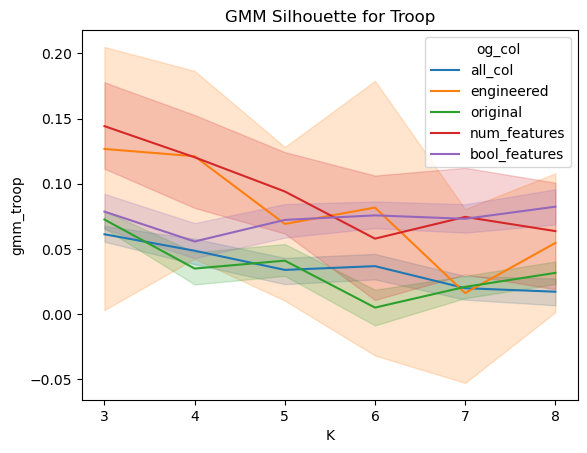

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=sim, x='K', y='gmm_troop', hue='og_col')
plt.title("GMM Silhouette for Troop")
plt.show()

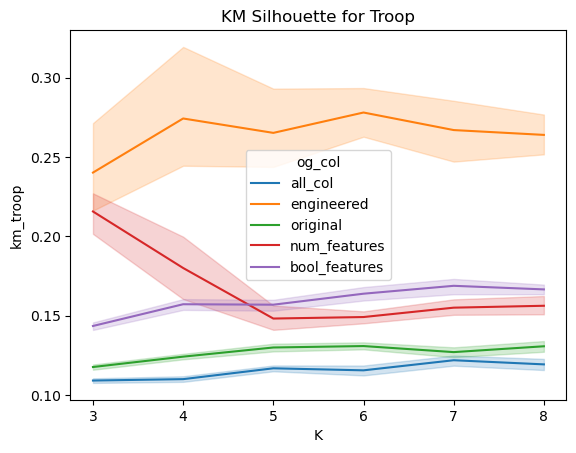

In [11]:
sns.lineplot(data=sim, x='K', y='km_troop', hue='og_col')
plt.title("KM Silhouette for Troop")
plt.show()

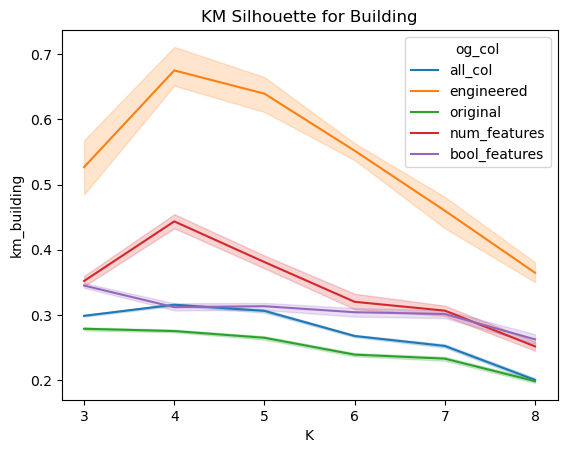

In [12]:
sns.lineplot(data=sim, x='K', y='km_building', hue='og_col')
plt.title("KM Silhouette for Building")
plt.show()

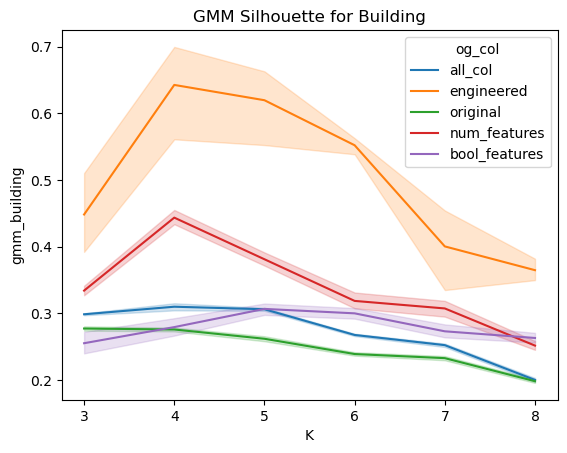

In [13]:
sns.lineplot(data=sim, x='K', y='gmm_building', hue='og_col')
plt.title("GMM Silhouette for Building")
plt.show()

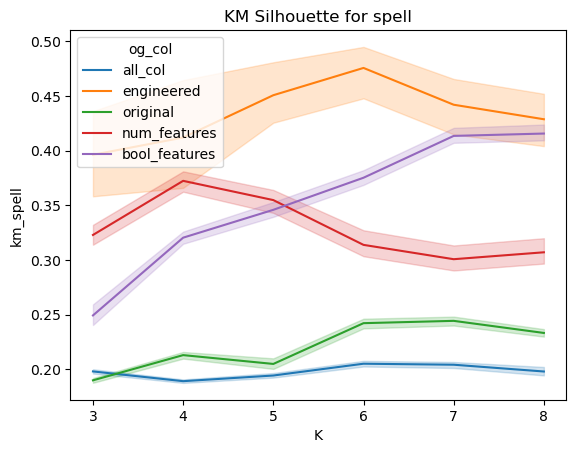

In [14]:
sns.lineplot(data=sim, x='K', y='km_spell', hue='og_col')
plt.title("KM Silhouette for spell")
plt.show()

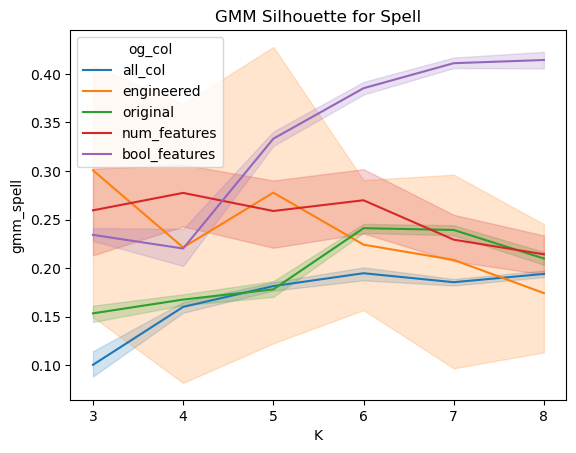

In [15]:
sns.lineplot(data=sim, x='K', y='gmm_spell', hue='og_col')
plt.title("GMM Silhouette for Spell")
plt.show()

In [16]:
sim.groupby(['og_col', 'K'])[
    ['gmm_troop', 'km_troop', 'gmm_spell', 'km_spell', 'gmm_building', 'km_building']
].mean()

gmm_troop  km_troop  gmm_spell  km_spell  gmm_building  \
og_col        K                                                           
all_col       3   0.061260  0.109120   0.100547  0.197973      0.298653   
              4   0.048633  0.110003   0.160162  0.189045      0.309983   
              5   0.033926  0.116842   0.181591  0.194222      0.306197   
              6   0.036807  0.115558   0.194815  0.205027      0.267661   
              7   0.019886  0.121924   0.185576  0.204109      0.252368   
              8   0.017193  0.119316   0.194091  0.197899      0.200209   
bool_features 3   0.078640  0.143522   0.234302  0.249235      0.255259   
              4   0.055719  0.157227   0.220261  0.320401      0.279435   
              5   0.072281  0.156941   0.333282  0.345899      0.306709   
              6   0.075763  0.163864   0.385245  0.375266      0.300050   
              7   0.073131  0.168841   0.410991  0.413550      0.273117   
              8   0.082414  0.166582   0.414301  0.415712      0.263128   
engineered    3   0.126717  0.240220   0.300715  0.396293      0.448241   
              4   0.121115  0.274322   0.221392  0.412036      0.642514   
              5   0.069195  0.265249   0.277769  0.450809      0.619573   
              6   0.081729  0.278086   0.224223  0.475773      0.552077   
              7   0.016154  0.267024   0.208513  0.442088      0.400408   
              8   0.054583  0.263978   0.174385  0.428799      0.364772   
num_features  3   0.144218  0.215697   0.259560  0.322888      0.334146   
              4   0.120319  0.180067   0.277510  0.372419      0.443549   
              5   0.094090  0.148208   0.258873  0.354804      0.381136   
              6   0.057904  0.149158   0.269924  0.313807      0.318701   
              7   0.074587  0.155065   0.229377  0.300690      0.307400   
              8   0.063695  0.156262   0.214297  0.307021      0.251686   
original      3   0.072559  0.117650   0.153511  0.189827      0.277305   
              4   0.034955  0.124183   0.167712  0.212895      0.275843   
              5   0.041021  0.129959   0.178212  0.204828      0.261946   
              6   0.005015  0.130865   0.241185  0.242140      0.239044   
              7   0.020906  0.127046   0.239334  0.244261      0.232876   
              8   0.031625  0.130726   0.209970  0.233186      0.198317   

                 km_building  
og_col        K               
all_col       3     0.298653  
              4     0.315625  
              5     0.306197  
              6     0.267661  
              7     0.252368  
              8     0.200209  
bool_features 3     0.345070  
              4     0.311880  
              5     0.313358  
              6     0.304126  
              7     0.301397  
              8     0.262491  
engineered    3     0.526897  
              4     0.675272  
              5     0.639590  
              6     0.552077  
              7     0.460018  
              8     0.364772  
num_features  3     0.352110  
              4     0.443549  
              5     0.381136  
              6     0.320122  
              7     0.306580  
              8     0.251686  
original      3     0.278757  
              4     0.275237  
              5     0.264886  
              6     0.239044  
              7     0.232876  
              8     0.198317

In [17]:
sim.groupby(['col', 'K']).agg({'gmm_troop': ['mean', 'std'], 'km_troop': ['mean', 'std']})

gmm_troop            km_troop          
                               mean       std      mean       std
col                     K                                        
affected_crown          3  0.094126  0.008280  0.124799  0.020214
                        4  0.069223  0.037659  0.133204  0.028431
                        5  0.030792  0.035756  0.140777  0.017097
                        6  0.030736  0.017356  0.146431  0.018452
                        7  0.043191  0.041455  0.149410  0.026193
                        8  0.045520  0.053020  0.131322  0.035580
air_control             3  0.048843  0.044723  0.120676  0.018083
                        4  0.016463  0.036054  0.133799  0.022673
                        5  0.015743  0.047331  0.123658  0.007315
                        6  0.032132  0.063110  0.137806  0.024282
                        7 -0.010683  0.047982  0.144042  0.027295
                        8  0.035399  0.032943  0.146583  0.023434
any_target              3  0.080361  0.023343  0.109444  0.012465
                        4  0.033898  0.026000  0.118099  0.018233
                        5  0.065076  0.019250  0.125828  0.016265
                        6  0.025195  0.058495  0.129916  0.019937
                        7  0.037686  0.053231  0.113771  0.037686
                        8 -0.030166  0.038779  0.133343  0.026435
aoe_bool                3  0.064388  0.055798  0.127585  0.021016
                        4  0.073929  0.018463  0.125580  0.024182
                        5  0.016709  0.081311  0.142278  0.019615
                        6  0.010192  0.097613  0.146507  0.031756
                        7  0.054610  0.035457  0.149663  0.016180
                        8  0.045572  0.057059  0.140079  0.028491
aoe_by_damage           3  0.100059  0.055804  0.180112  0.054743
                        4  0.063544  0.051580  0.174364  0.079882
                        5  0.080181  0.117986  0.176884  0.057111
                        6 -0.046563  0.046565  0.175699  0.064230
                        7  0.006029  0.135561  0.166035  0.050260
                        8  0.032133  0.006325  0.169984  0.071133
aoe_by_range            3  0.165719  0.047139  0.172907  0.067758
                        4  0.056075  0.136134  0.161017  0.058812
                        5  0.073548  0.066198  0.174858  0.060358
                        6 -0.043072  0.118946  0.165811  0.082756
                        7  0.036591  0.060059  0.178533  0.062770
                        8  0.036805  0.095696  0.180924  0.071318
aoe_per_elixir          3  0.085487  0.030774  0.150879  0.066917
                        4  0.073454  0.069309  0.124840  0.008265
                        5  0.020414  0.061679  0.129167  0.007751
                        6  0.043141  0.014311  0.142188  0.015065
                        7  0.065467  0.089365  0.126196  0.015011
                        8  0.083131  0.019143  0.137227  0.014154
aoe_radius              3  0.079076  0.065682  0.149200  0.058189
                        4  0.092485  0.065739  0.129380  0.012691
                        5  0.040463  0.046285  0.142208  0.024325
                        6 -0.009554  0.143278  0.143503  0.012084
                        7  0.079103  0.059993  0.125789  0.026364
                        8  0.067830  0.046025  0.128673  0.013324
attack_count            3  0.133584  0.161947  0.128658  0.013192
                        4  0.079198  0.093078  0.129883  0.022146
                        5  0.062360  0.046702  0.126084  0.025517
                        6  0.071521  0.091191  0.126391  0.018459
                        7  0.076852  0.081896  0.130984  0.018297
                        8  0.052913  0.064331  0.143148  0.008717
building_target         3  0.080361  0.023343  0.109444  0.012465
                        4  0.033898  0.026000  0.118099  0.018233
                        5  0.065076  0.019250  0.125828  0.016265
                        6  0.025195  0.058495  0.129916  0.019937


In [18]:
sim.groupby(['col', 'K']).agg({'gmm_spell': ['mean', 'std'], 'km_spell': ['mean', 'std']})

gmm_spell            km_spell          
                               mean       std      mean       std
col                     K                                        
affected_crown          3  0.138686  0.044009  0.187460  0.025032
                        4  0.188749  0.072113  0.226947  0.072607
                        5  0.244867  0.099078  0.239425  0.093986
                        6  0.270288  0.100357  0.275674  0.094733
                        7  0.256897  0.134264  0.274707  0.118895
                        8  0.273843  0.119563  0.273002  0.120578
air_control             3  0.153863  0.085098  0.207707  0.025780
                        4  0.169765  0.003567  0.240889  0.069265
                        5  0.226818  0.090737  0.241187  0.084910
                        6  0.278958  0.092142  0.271354  0.083002
                        7  0.280188  0.115289  0.287638  0.106429
                        8  0.264643  0.124961  0.277459  0.114905
any_target              3  0.153863  0.085098  0.207707  0.025780
                        4  0.169765  0.003567  0.240889  0.069265
                        5  0.226818  0.090737  0.241187  0.084910
                        6  0.278958  0.092142  0.271354  0.083002
                        7  0.280188  0.115289  0.287638  0.106429
                        8  0.264643  0.124961  0.277459  0.114905
aoe_bool                3  0.184535  0.056828  0.227512  0.036142
                        4  0.227074  0.075593  0.252768  0.080316
                        5  0.246722  0.135133  0.272915  0.102928
                        6  0.265259  0.090838  0.281466  0.117486
                        7  0.256782  0.110285  0.263967  0.129607
                        8  0.293481  0.125139  0.300665  0.118047
aoe_by_damage           3  0.279093  0.081564  0.286520  0.083200
                        4  0.253035  0.143334  0.304328  0.108161
                        5  0.166672  0.123682  0.325137  0.124528
                        6  0.174629  0.147134  0.327749  0.134740
                        7  0.217242  0.031639  0.305809  0.125223
                        8  0.144112  0.052752  0.309131  0.129905
aoe_by_range            3  0.228539  0.233126  0.328012  0.151065
                        4  0.340909  0.192609  0.366913  0.179497
                        5  0.315952  0.180548  0.356488  0.160371
                        6  0.274172  0.060852  0.337611  0.148437
                        7  0.269159  0.095590  0.306814  0.116405
                        8  0.209207  0.021154  0.307684  0.094665
aoe_per_elixir          3  0.208986  0.084176  0.226137  0.069113
                        4  0.194701  0.060488  0.256510  0.102518
                        5  0.144451  0.063708  0.262173  0.091890
                        6  0.243434  0.021087  0.266872  0.055866
                        7  0.242560  0.029311  0.259791  0.047340
                        8  0.240328  0.041750  0.247079  0.040354
aoe_radius              3  0.129129  0.063145  0.224290  0.050696
                        4  0.214561  0.073477  0.250974  0.092498
                        5  0.211012  0.040305  0.257918  0.082032
                        6  0.249788  0.034688  0.256075  0.035119
                        7  0.226827  0.061839  0.249099  0.044922
                        8  0.220210  0.038774  0.263056  0.054472
attack_count            3  0.183464  0.070055  0.252466  0.086925
                        4  0.205856  0.063417  0.285640  0.119548
                        5  0.225756  0.061988  0.258835  0.091906
                        6  0.246498  0.107457  0.265717  0.088768
                        7  0.200769  0.013846  0.273571  0.078962
                        8  0.224900  0.039150  0.270686  0.101750
building_target         3  0.153863  0.085098  0.207707  0.025780
                        4  0.169765  0.003567  0.240889  0.069265
                        5  0.226818  0.090737  0.241187  0.084910
                        6  0.278958  0.092142  0.271354  0.083002


In [19]:
sim.groupby(['col', 'K']).agg({'gmm_building': ['mean', 'std'], 'km_building': ['mean', 'std']})

gmm_building           km_building          
                                  mean       std        mean       std
col                     K                                             
affected_crown          3     0.276063  0.037904    0.317661  0.035941
                        4     0.283669  0.040745    0.310357  0.021676
                        5     0.277462  0.024232    0.279732  0.028038
                        6     0.255512  0.015445    0.255512  0.015445
                        7     0.227350  0.022887    0.243840  0.047660
                        8     0.215071  0.033305    0.215071  0.033305
air_control             3     0.302319  0.016955    0.310023  0.029025
                        4     0.313351  0.013827    0.312872  0.033104
                        5     0.278114  0.033707    0.278114  0.033707
                        6     0.280608  0.021473    0.279008  0.019039
                        7     0.247580  0.022943    0.250454  0.024000
                        8     0.222259  0.021125    0.222259  0.021125
any_target              3     0.266780  0.038567    0.303061  0.027318
                        4     0.277490  0.051786    0.296680  0.027381
                        5     0.275872  0.037461    0.295006  0.021510
                        6     0.274542  0.020862    0.274542  0.020862
                        7     0.260733  0.029861    0.260733  0.029861
                        8     0.218738  0.031651    0.218738  0.031651
aoe_bool                3     0.290350  0.025555    0.304410  0.057742
                        4     0.287848  0.066374    0.308819  0.047751
                        5     0.297225  0.047393    0.297225  0.047393
                        6     0.278035  0.059866    0.278035  0.059866
                        7     0.270116  0.062578    0.270116  0.062578
                        8     0.231270  0.073309    0.231270  0.073309
aoe_by_damage           3     0.328229  0.032723    0.383883  0.121659
                        4     0.470417  0.174641    0.470417  0.174641
                        5     0.436434  0.179270    0.436434  0.179270
                        6     0.377467  0.155510    0.377467  0.155510
                        7     0.344932  0.117378    0.344932  0.117378
                        8     0.263285  0.074940    0.263285  0.074940
aoe_by_range            3     0.342124  0.058068    0.375992  0.114591
                        4     0.439929  0.200352    0.463926  0.165918
                        5     0.437247  0.168132    0.437247  0.168132
                        6     0.373687  0.151137    0.373687  0.151137
                        7     0.341152  0.113236    0.341152  0.113236
                        8     0.262546  0.075965    0.262546  0.075965
aoe_per_elixir          3     0.297024  0.035505    0.293842  0.039911
                        4     0.314338  0.109563    0.338312  0.092232
                        5     0.304968  0.056767    0.304968  0.056767
                        6     0.268756  0.042471    0.268756  0.042471
                        7     0.260979  0.044448    0.260979  0.044448
                        8     0.211156  0.035860    0.211156  0.035860
aoe_radius              3     0.297024  0.035505    0.293842  0.039911
                        4     0.314338  0.109563    0.338312  0.092232
                        5     0.304968  0.056767    0.304968  0.056767
                        6     0.268756  0.042471    0.268756  0.042471
                        7     0.260979  0.044448    0.260979  0.044448
                        8     0.211156  0.035860    0.211156  0.035860
attack_count            3     0.307743  0.042009    0.307743  0.042009
                        4     0.326896  0.076338    0.331255  0.070635
                        5     0.301784  0.047728    0.301784  0.047728
                        6     0.257213  0.029333    0.257213  0.029333
                        7     0.240046  0.015218    0.249691  0.029991
                        8     0.214721  0.032700  

In [20]:
troop_important = sim[sim['og_col'] == 'num_features'].sort_values('gmm_troop').head(10)['col'].tolist()

# spell
spell_important = sim[sim['og_col'] == 'engineered'].sort_values('gmm_spell').head(10)['col'].tolist()

# building
building_important = sim[sim['og_col'] == 'engineered'].sort_values('gmm_building').head(10)['col'].tolist()

In [21]:
sim.groupby('col')['gmm_troop'].mean().sort_values()

col
damage_output_ps           0.012572
air_control                0.022983
ground_dps                 0.023217
is_spawned                 0.023793
has_lifetime               0.034386
playable                   0.035299
is_free_card               0.035299
any_target                 0.035342
building_target            0.035342
spawn_bool                 0.039106
aoe_by_damage              0.039231
ground_target              0.039328
no_hitpoints               0.040046
win_con_dmg                0.040999
has_upon_death_spawn       0.042482
fly_bool                   0.042782
is_building                0.044201
is_spell                   0.044201
is_troop                   0.044201
is_tower_troop             0.044201
aoe_bool                   0.044233
no_hit_speed               0.045501
win_con                    0.046168
has_friendly_buff          0.046380
high_dps                   0.048562
death_damage_bool          0.050664
invisible                  0.050738
control_special         

In [22]:
sim.groupby('col')['gmm_spell'].mean().sort_values()

col
can_evolve                 0.175107
damage_per_elixir          0.180268
damage                     0.192944
damage_per_second          0.197319
damage_by_hitpoints        0.197319
damage_output              0.205633
aoe_by_damage              0.205797
aoe_radius                 0.208588
damage_output_ps           0.209873
hitpoints                  0.209873
speed                      0.209873
range                      0.209873
hit_speed                  0.209873
count                      0.209873
aoe_per_elixir             0.212410
high_dps                   0.212765
attack_count               0.214540
dps_special                0.223048
no_attack                  0.223277
has_upon_breaking_spawn    0.224756
support                    0.225132
affected_crown             0.228888
invisible                  0.229039
is_building                0.229039
is_free_card               0.229039
playable                   0.229039
no_hitpoints               0.229039
is_troop                

In [23]:
sim.groupby('col')['gmm_building'].mean().sort_values()

col
ground_target              0.255645
building_target            0.255645
affected_crown             0.255854
any_target                 0.262359
special_damage             0.262609
control_special            0.262609
no_attack                  0.262645
support                    0.262645
spawn_bool                 0.263462
has_upon_death_spawn       0.263462
fly_bool                   0.264541
no_hitpoints               0.264597
has_ability                0.264597
has_lifetime               0.264597
win_con                    0.264597
has_upon_breaking_spawn    0.264597
is_spawned                 0.264597
is_building                0.264597
shield_bool                0.264597
is_tower_troop             0.264597
is_troop                   0.264597
mini_tank                  0.264597
invisible                  0.264597
is_spell                   0.264597
win_con_dmg                0.264597
dps_special                0.264597
special_attack_type        0.264893
no_hit_speed            

In [24]:
sim

,gmm_troop,km_troop,gmm_spell,km_spell,gmm_building,km_building,K,col,og_col
0,0.100037,0.101809,0.062831,0.196593,0.303626,0.303626,3,playable,all_col
1,0.062340,0.110193,0.211933,0.211933,0.289034,0.289034,3,aoe_bool,all_col
2,0.056719,0.110700,0.075182,0.205529,0.290237,0.290237,3,aoe_radius,all_col
3,0.035059,0.114044,0.062831,0.196593,0.309203,0.309203,3,death_damage_bool,all_col
4,0.040841,0.111170,0.062831,0.196593,0.298635,0.298635,3,fly_bool,all_col
5,0.054749,0.114876,0.168812,0.196606,0.294232,0.294232,3,spawn_bool,all_col
6,0.084860,0.110139,0.141692,0.212579,0.314256,0.314256,3,can_evolve,all_col
7,0.097165,0.101387,0.142337,0.206865,0.308941,0.308941,3,elixircost,all_col
8,0.092766,0.115080,0.062831,0.196593,0.301437,0.301437,3,hit_speed,all_col
9,0.034007,0.106351,0.195995,0.183295,0.305407,0.305407,3,special_damage,all_col


In [25]:
troop_impact = (
    sim[sim['K'].isin([6, 7])]
    .groupby('col')['gmm_troop']
    .mean()
    .sort_values()
)
print(troop_impact.head(20))

col
aoe_by_damage         -0.020267
is_spawned            -0.011287
speed                 -0.003281
aoe_by_range          -0.003241
special_attack_type   -0.001641
damage_output_ps      -0.000958
has_lifetime           0.009991
air_control            0.010725
ground_target          0.011816
can_evolve             0.016588
ground_dps             0.017981
no_hit_speed           0.018220
spawn_bool             0.019521
control_special        0.022448
fly_bool               0.027837
hit_speed              0.031415
building_target        0.031441
any_target             0.031441
aoe_bool               0.032401
is_free_card           0.033195
Name: gmm_troop, dtype: float64


In [26]:
spell_impact = (
    sim[sim['K'].isin([3, 4])]
    .groupby('col')['gmm_spell']
    .mean()
    .sort_values()
)
print(spell_impact.head(20))

col
can_evolve                 0.117799
has_upon_breaking_spawn    0.157633
no_attack                  0.160526
win_con_dmg                0.161814
ground_target              0.161814
ground_dps                 0.161814
fly_bool                   0.161814
win_con                    0.161814
has_ranged_attack          0.161814
death_damage_bool          0.161814
has_upon_death_spawn       0.161814
invisible                  0.161814
is_building                0.161814
is_free_card               0.161814
is_spell                   0.161814
is_tower_troop             0.161814
is_troop                   0.161814
building_target            0.161814
mini_tank                  0.161814
no_hit_speed               0.161814
Name: gmm_spell, dtype: float64


In [27]:
building_impact = (
    sim[sim['K'].isin([3, 4])]
    .groupby('col')['gmm_building']
    .mean()
    .sort_values()
)
print(spell_impact.head(20))

col
can_evolve                 0.117799
has_upon_breaking_spawn    0.157633
no_attack                  0.160526
win_con_dmg                0.161814
ground_target              0.161814
ground_dps                 0.161814
fly_bool                   0.161814
win_con                    0.161814
has_ranged_attack          0.161814
death_damage_bool          0.161814
has_upon_death_spawn       0.161814
invisible                  0.161814
is_building                0.161814
is_free_card               0.161814
is_spell                   0.161814
is_tower_troop             0.161814
is_troop                   0.161814
building_target            0.161814
mini_tank                  0.161814
no_hit_speed               0.161814
Name: gmm_spell, dtype: float64


In [28]:
troop_col = [
    'elixircost',             # Cost is critical
    'damage_per_second',      # Core damage
    'range',                  # Ranged vs melee
    'spawn_bool',             # Swarmers / spawners
    'hitpoints',              # Tankiness
    'has_ranged_attack',      # Categorical indicator
    'aoe_bool',
    'win_con',
    'attack_count',
    'has_ability',
    'dps_special',
]

spell_features_final = [
    'damage', 'speed', 'hit_speed', 'hitpoints', 'range', 'count',
    'damage_output', 'aoe_per_elixir', 'damage_per_second', 'damage_by_hitpoints'
]
building_features_final = [
    'damage', 'damage_output', 'damage_per_second', 'damage_by_hitpoints',
    'hitpoints', 'hp_per_elixir', 'aoe_per_elixir', 'elixircost',
    'spawn_bool', 'has_upon_death_spawn'
]
final_troop = create_clusters('troop', 8, troop_col)
final_spell = create_clusters('spell', 3, spell_features_final)
final_building = create_clusters('building', 4, building_features_final)

def plot_feature_k_sensitivity(sim, colname, unit_type):
    df = sim[sim['col'] == colname]
    sns.lineplot(data=df, x='K', y=f'gmm_{unit_type}')
    plt.title(f'Silhouette after removing {colname} ({unit_type})')
    plt.ylim(0, 1)
    plt.show()

final_troop['sil_km']

0.23727053784978042

In [29]:
def print_cluster_sizes(labels):
    from collections import Counter
    size_dict = Counter(labels)
    total = sum(size_dict.values())
    for k, v in sorted(size_dict.items()):
        print(f"Cluster {k}: {v} cards ({v/total:.2%})")
troop_result = create_clusters('troop', 8, troop_col)
print_cluster_sizes(troop_result['km_labels'])

Cluster 0: 18 cards (17.82%)
Cluster 1: 12 cards (11.88%)
Cluster 2: 13 cards (12.87%)
Cluster 3: 18 cards (17.82%)
Cluster 4: 18 cards (17.82%)
Cluster 5: 8 cards (7.92%)
Cluster 6: 8 cards (7.92%)
Cluster 7: 6 cards (5.94%)


In [30]:
for i, cluster in enumerate(troop_result['km_clusters']):
    print(f"\nCluster {i} ({len(cluster)} cards):")
    print(", ".join(cluster))  # no .values or .flatten needed


Cluster 0 (18 cards):
Archers, Cannon Cart, Dart Goblin, Electro Dragon, Electro Wizard, Flying Machine, Furnace, Inferno Dragon, Mega Minion, Minions, Mother Witch, Musketeer, Rascals, Spear Goblins, Spirit Empress (Ranged), Three Musketeers, Zappies, Rascal Girl

Cluster 1 (12 cards):
Barbarians, Bats, Electro Spirit, Goblin Gang, Goblins, Guards, Hunter, Minion Horde, Royal Recruits, Skeleton Army, Skeletons, Lava Pup

Cluster 2 (13 cards):
Elixir Golem, Hog Rider, Ice Golem, Royal Hogs, Rune Giant, Skeleton Barrel, Suspicious Bush, Wall Breakers, Cursed Hog, Elixir Blob, Elixir Golemite, Golemite, Monster

Cluster 3 (18 cards):
Balloon, Bandit, Berserker, Elite Barbarians, Fisherman, Knight, Lumberjack, Miner, Mini P.E.K.K.A, Night Witch, P.E.K.K.A, Spirit Empress (Melee), Valkyrie, Bush Goblins, Goblin Brawler, Guardienne, Reborn Phoenix, Rascal Boy

Cluster 4 (18 cards):
Baby Dragon, Battle Healer, Bomber, Executioner, Fire Spirit, Firecracker, Goblin Demolisher, Goblin Machine,

In [31]:
troop_result['km_clusters']

[['Archers',
  'Cannon Cart',
  'Dart Goblin',
  'Electro Dragon',
  'Electro Wizard',
  'Flying Machine',
  'Furnace',
  'Inferno Dragon',
  'Mega Minion',
  'Minions',
  'Mother Witch',
  'Musketeer',
  'Rascals',
  'Spear Goblins',
  'Spirit Empress (Ranged)',
  'Three Musketeers',
  'Zappies',
  'Rascal Girl'],
 ['Barbarians',
  'Bats',
  'Electro Spirit',
  'Goblin Gang',
  'Goblins',
  'Guards',
  'Hunter',
  'Minion Horde',
  'Royal Recruits',
  'Skeleton Army',
  'Skeletons',
  'Lava Pup'],
 ['Elixir Golem',
  'Hog Rider',
  'Ice Golem',
  'Royal Hogs',
  'Rune Giant',
  'Skeleton Barrel',
  'Suspicious Bush',
  'Wall Breakers',
  'Cursed Hog',
  'Elixir Blob',
  'Elixir Golemite',
  'Golemite',
  'Monster'],
 ['Balloon',
  'Bandit',
  'Berserker',
  'Elite Barbarians',
  'Fisherman',
  'Knight',
  'Lumberjack',
  'Miner',
  'Mini P.E.K.K.A',
  'Night Witch',
  'P.E.K.K.A',
  'Spirit Empress (Melee)',
  'Valkyrie',
  'Bush Goblins',
  'Goblin Brawler',
  'Guardienne',
  'Reborn

In [32]:
from sklearn.cluster import SpectralClustering

X = cards[cards['is_troop']][troop_col]
Xs = StandardScaler().fit_transform(X)

spec = SpectralClustering(n_clusters=8, assign_labels='kmeans', random_state=42)
spec_labels = spec.fit_predict(Xs)

print_cluster_sizes(spec_labels)

Cluster 0: 16 cards (15.84%)
Cluster 1: 8 cards (7.92%)
Cluster 2: 3 cards (2.97%)
Cluster 3: 3 cards (2.97%)
Cluster 4: 59 cards (58.42%)
Cluster 5: 4 cards (3.96%)
Cluster 6: 7 cards (6.93%)
Cluster 7: 1 cards (0.99%)


In [33]:
troop_result['km_clusters']

[['Archers',
  'Cannon Cart',
  'Dart Goblin',
  'Electro Dragon',
  'Electro Wizard',
  'Flying Machine',
  'Furnace',
  'Inferno Dragon',
  'Mega Minion',
  'Minions',
  'Mother Witch',
  'Musketeer',
  'Rascals',
  'Spear Goblins',
  'Spirit Empress (Ranged)',
  'Three Musketeers',
  'Zappies',
  'Rascal Girl'],
 ['Barbarians',
  'Bats',
  'Electro Spirit',
  'Goblin Gang',
  'Goblins',
  'Guards',
  'Hunter',
  'Minion Horde',
  'Royal Recruits',
  'Skeleton Army',
  'Skeletons',
  'Lava Pup'],
 ['Elixir Golem',
  'Hog Rider',
  'Ice Golem',
  'Royal Hogs',
  'Rune Giant',
  'Skeleton Barrel',
  'Suspicious Bush',
  'Wall Breakers',
  'Cursed Hog',
  'Elixir Blob',
  'Elixir Golemite',
  'Golemite',
  'Monster'],
 ['Balloon',
  'Bandit',
  'Berserker',
  'Elite Barbarians',
  'Fisherman',
  'Knight',
  'Lumberjack',
  'Miner',
  'Mini P.E.K.K.A',
  'Night Witch',
  'P.E.K.K.A',
  'Spirit Empress (Melee)',
  'Valkyrie',
  'Bush Goblins',
  'Goblin Brawler',
  'Guardienne',
  'Reborn

In [34]:
feature_groups = {
    'core_identity': [
        'playable', 'is_spawned',
        'no_hit_speed', 'no_attack', 'has_ranged_attack'
    ],
    'combat_core_stats': [
        'elixircost', 'damage', 'hitpoints', 'hit_speed', 'attack_count',
        'range', 'speed', 'count'
    ],
    'targeting_behavior': [
        'any_target', 'ground_target', 'building_target'
    ],
    'special_attack_mechanics': [
        'special_damage', 'special_attack_type', 'has_ranged_attack',
        'has_ability', 'has_friendly_buff', 'invisible', 'aoe_bool'
    ],
    'boolean_effects_and_traits': [
        'aoe_bool', 'death_damage_bool', 'fly_bool', 'spawn_bool', 'can_evolve',
        'shield_bool', 'has_lifetime', 'has_upon_breaking_spawn',
        'has_upon_death_spawn', 'has_periodic_spawn', 'single_damage_type'
    ],
    'engineered_features': [
        'damage_per_elixir', 'damage_per_second', 'damage_output',
        'hp_per_elixir', 'damage_by_hitpoints', 'aoe_by_range',
        'aoe_by_damage', 'aoe_per_elixir', 'control_special',
        'dps_special', 'air_control', 'ground_dps', 'damage_output_ps'
    ],
    'role_labels': [
        'win_con', 'win_con_dmg', 'support', 'mini_tank', 'high_dps',
    ],
    
    'highest_troop': [
        'elixircost', 'damage_per_second',
        'range', 'spawn_bool', 'hitpoints',
        'has_ranged_attack', 'aoe_bool', 'win_con',
        'attack_count', 'has_ability', 'dps_special',
    ]
}

In [35]:
def simulation_n(add_col=[]):
    simulation = []
    for k in range(3, 9):
        for title, num_col in feature_groups.items():
            for col in num_col:
                test_col = num_col.copy()
                test_col.remove(col)
                
            
                sim_troop = create_clusters('troop', k, test_col + add_col)
                sil_gmm_troop = sim_troop['sil_gmm']
                sil_km_troop = sim_troop['sil_km']

                sim_spell = create_clusters('spell', k, test_col + add_col)
                sil_gmm_spell = sim_spell['sil_gmm']
                sil_km_spell = sim_spell['sil_km']

                sim_building = create_clusters('building', k, test_col + add_col)
                sil_gmm_building = sim_building['sil_gmm']
                sil_km_building = sim_building['sil_km']

                simulation.append(
                    {
                    'gmm_troop':sil_gmm_troop, 
                    'km_troop': sil_km_troop, 
                    'gmm_spell': sil_gmm_spell, 
                    'km_spell':sil_km_spell, 
                    'gmm_building':sil_gmm_building, 
                    'km_building':sil_km_building, 
                    'K': k,
                    'col': col,
                    'og_col': title
                    }
                )
    
    simulation_df = pd.DataFrame(simulation)
    
    return simulation_df
sim2 = simulation_n()

/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters 

In [36]:
sim2

,gmm_troop,km_troop,gmm_spell,km_spell,gmm_building,km_building,K,col,og_col
0,0.575372,0.603388,0.952381,0.952381,0.791102,0.791102,3,playable,core_identity
1,0.714769,0.619159,1.000000,1.000000,0.732222,0.732222,3,is_spawned,core_identity
2,0.624338,0.770655,0.952381,0.952381,0.664868,0.664868,3,no_hit_speed,core_identity
3,0.653460,0.648924,0.952381,0.952381,0.794282,0.794282,3,no_attack,core_identity
4,0.827262,0.754081,0.952381,0.952381,0.794282,0.794282,3,has_ranged_attack,core_identity
5,0.100138,0.243560,0.292380,0.643807,0.441692,0.441692,3,elixircost,combat_core_stats
6,0.197039,0.240286,0.172046,0.494932,0.157421,0.325686,3,damage,combat_core_stats
7,0.105611,0.220023,0.512957,0.497479,0.418001,0.418001,3,hitpoints,combat_core_stats
8,0.154633,0.232560,0.512957,0.497479,0.391532,0.443722,3,hit_speed,combat_core_stats
9,0.149723,0.227099,0.333605,0.465754,0.249178,0.362853,3,attack_count,combat_core_stats


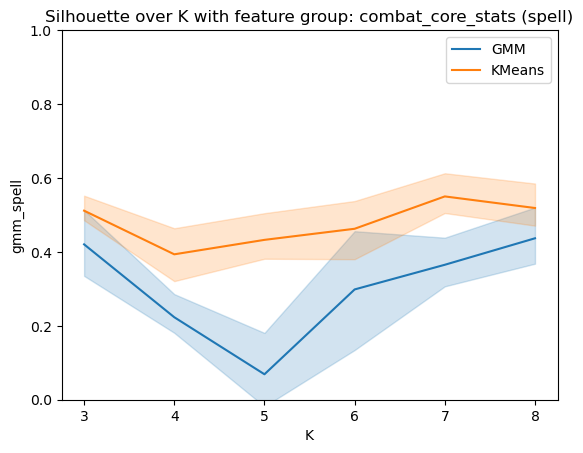

In [37]:
def plot_feature_group_scores(sim_df, og_col_filter, unit_type):
    df = sim_df[sim_df['og_col'] == og_col_filter]
    sns.lineplot(data=df, x='K', y=f'gmm_{unit_type}', label='GMM')
    sns.lineplot(data=df, x='K', y=f'km_{unit_type}', label='KMeans')
    plt.title(f'Silhouette over K with feature group: {og_col_filter} ({unit_type})')
    plt.ylim(0, 1)
    plt.show()
plot_feature_group_scores(sim2, 'combat_core_stats', 'spell')

In [38]:
combat_result = create_clusters('troop', 12, feature_groups['combat_core_stats'])
print_cluster_sizes(combat_result['km_labels'])

Cluster 0: 8 cards (7.92%)
Cluster 1: 23 cards (22.77%)
Cluster 2: 9 cards (8.91%)
Cluster 3: 1 cards (0.99%)
Cluster 4: 18 cards (17.82%)
Cluster 5: 10 cards (9.90%)
Cluster 6: 1 cards (0.99%)
Cluster 7: 13 cards (12.87%)
Cluster 8: 2 cards (1.98%)
Cluster 9: 3 cards (2.97%)
Cluster 10: 9 cards (8.91%)
Cluster 11: 4 cards (3.96%)


In [39]:
target_result = create_clusters('troop', 3, feature_groups['targeting_behavior'])
print_cluster_sizes(target_result['km_labels'])

Cluster 0: 22 cards (21.78%)
Cluster 1: 38 cards (37.62%)
Cluster 2: 41 cards (40.59%)


In [40]:
special_result = create_clusters('troop', 18, feature_groups['special_attack_mechanics'])
print_cluster_sizes(special_result['gmm_labels'])

Cluster 0: 32 cards (31.68%)
Cluster 1: 5 cards (4.95%)
Cluster 2: 3 cards (2.97%)
Cluster 3: 3 cards (2.97%)
Cluster 4: 2 cards (1.98%)
Cluster 5: 15 cards (14.85%)
Cluster 6: 3 cards (2.97%)
Cluster 7: 4 cards (3.96%)
Cluster 8: 8 cards (7.92%)
Cluster 9: 5 cards (4.95%)
Cluster 10: 6 cards (5.94%)
Cluster 11: 2 cards (1.98%)
Cluster 12: 3 cards (2.97%)
Cluster 13: 2 cards (1.98%)
Cluster 14: 2 cards (1.98%)
Cluster 15: 1 cards (0.99%)
Cluster 16: 2 cards (1.98%)
Cluster 17: 3 cards (2.97%)


In [41]:
bool_result = create_clusters('troop', 23, feature_groups['boolean_effects_and_traits'])
print_cluster_sizes(bool_result['gmm_labels'])

Cluster 0: 6 cards (5.94%)
Cluster 1: 30 cards (29.70%)
Cluster 2: 3 cards (2.97%)
Cluster 3: 1 cards (0.99%)
Cluster 4: 1 cards (0.99%)
Cluster 5: 3 cards (2.97%)
Cluster 6: 2 cards (1.98%)
Cluster 7: 3 cards (2.97%)
Cluster 8: 4 cards (3.96%)
Cluster 9: 7 cards (6.93%)
Cluster 10: 4 cards (3.96%)
Cluster 11: 2 cards (1.98%)
Cluster 12: 9 cards (8.91%)
Cluster 13: 8 cards (7.92%)
Cluster 14: 4 cards (3.96%)
Cluster 15: 1 cards (0.99%)
Cluster 16: 2 cards (1.98%)
Cluster 17: 1 cards (0.99%)
Cluster 18: 2 cards (1.98%)
Cluster 19: 2 cards (1.98%)
Cluster 20: 3 cards (2.97%)
Cluster 21: 1 cards (0.99%)
Cluster 22: 2 cards (1.98%)


In [42]:
eng_result = create_clusters('troop', 13, feature_groups['engineered_features'])
print_cluster_sizes(eng_result['km_labels'])

Cluster 0: 10 cards (9.90%)
Cluster 1: 5 cards (4.95%)
Cluster 2: 20 cards (19.80%)
Cluster 3: 13 cards (12.87%)
Cluster 4: 1 cards (0.99%)
Cluster 5: 7 cards (6.93%)
Cluster 6: 8 cards (7.92%)
Cluster 7: 5 cards (4.95%)
Cluster 8: 1 cards (0.99%)
Cluster 9: 13 cards (12.87%)
Cluster 10: 3 cards (2.97%)
Cluster 11: 3 cards (2.97%)
Cluster 12: 12 cards (11.88%)


In [43]:
test_result = create_clusters('troop', 23, feature_groups['highest_troop'])
print_cluster_sizes(test_result['km_labels'])

Cluster 0: 11 cards (10.89%)
Cluster 1: 5 cards (4.95%)
Cluster 2: 4 cards (3.96%)
Cluster 3: 11 cards (10.89%)
Cluster 4: 4 cards (3.96%)
Cluster 5: 6 cards (5.94%)
Cluster 6: 3 cards (2.97%)
Cluster 7: 3 cards (2.97%)
Cluster 8: 3 cards (2.97%)
Cluster 9: 1 cards (0.99%)
Cluster 10: 12 cards (11.88%)
Cluster 11: 4 cards (3.96%)
Cluster 12: 4 cards (3.96%)
Cluster 13: 3 cards (2.97%)
Cluster 14: 4 cards (3.96%)
Cluster 15: 2 cards (1.98%)
Cluster 16: 2 cards (1.98%)
Cluster 17: 6 cards (5.94%)
Cluster 18: 1 cards (0.99%)
Cluster 19: 4 cards (3.96%)
Cluster 20: 2 cards (1.98%)
Cluster 21: 1 cards (0.99%)
Cluster 22: 5 cards (4.95%)


In [44]:
role_result = create_clusters('troop', 9, feature_groups['role_labels'])
print_cluster_sizes(role_result['gmm_labels'])

Cluster 0: 7 cards (6.93%)
Cluster 1: 41 cards (40.59%)
Cluster 2: 24 cards (23.76%)
Cluster 3: 5 cards (4.95%)
Cluster 4: 5 cards (4.95%)
Cluster 5: 6 cards (5.94%)
Cluster 6: 8 cards (7.92%)
Cluster 7: 3 cards (2.97%)
Cluster 8: 2 cards (1.98%)


In [45]:
combined_result = create_clusters('troop', 23, feature_groups['engineered_features'] + feature_groups['boolean_effects_and_traits'])
print_cluster_sizes(combined_result['km_labels'])

Cluster 0: 9 cards (8.91%)
Cluster 1: 9 cards (8.91%)
Cluster 2: 1 cards (0.99%)
Cluster 3: 14 cards (13.86%)
Cluster 4: 2 cards (1.98%)
Cluster 5: 6 cards (5.94%)
Cluster 6: 2 cards (1.98%)
Cluster 7: 8 cards (7.92%)
Cluster 8: 5 cards (4.95%)
Cluster 9: 1 cards (0.99%)
Cluster 10: 2 cards (1.98%)
Cluster 11: 4 cards (3.96%)
Cluster 12: 3 cards (2.97%)
Cluster 13: 6 cards (5.94%)
Cluster 14: 7 cards (6.93%)
Cluster 15: 1 cards (0.99%)
Cluster 16: 5 cards (4.95%)
Cluster 17: 2 cards (1.98%)
Cluster 18: 4 cards (3.96%)
Cluster 19: 1 cards (0.99%)
Cluster 20: 4 cards (3.96%)
Cluster 21: 1 cards (0.99%)
Cluster 22: 4 cards (3.96%)


In [46]:
for feature_group_name, col_list in list(feature_groups.items())[1:]:
    for k in range(6, 30):
        result = create_clusters('troop', k, col_list)
        score = [result['sil_gmm'], result['sil_km']]
        print(f"{feature_group_name}, K={k} -> score(gmm, km)=({score[0]:.3f}, {score[1]:.3f})")

combat_core_stats, K=6 -> score(gmm, km)=(-0.029, 0.206)
combat_core_stats, K=7 -> score(gmm, km)=(0.099, 0.215)
combat_core_stats, K=8 -> score(gmm, km)=(-0.006, 0.220)
combat_core_stats, K=9 -> score(gmm, km)=(-0.019, 0.239)
combat_core_stats, K=10 -> score(gmm, km)=(0.082, 0.249)
combat_core_stats, K=11 -> score(gmm, km)=(0.052, 0.232)
combat_core_stats, K=12 -> score(gmm, km)=(0.038, 0.250)
combat_core_stats, K=13 -> score(gmm, km)=(0.073, 0.228)
combat_core_stats, K=14 -> score(gmm, km)=(0.047, 0.210)
combat_core_stats, K=15 -> score(gmm, km)=(0.053, 0.233)
combat_core_stats, K=16 -> score(gmm, km)=(0.081, 0.243)
combat_core_stats, K=17 -> score(gmm, km)=(-0.116, 0.221)
combat_core_stats, K=18 -> score(gmm, km)=(-0.012, 0.217)
combat_core_stats, K=19 -> score(gmm, km)=(0.037, 0.218)
combat_core_stats, K=20 -> score(gmm, km)=(-0.243, 0.233)
combat_core_stats, K=21 -> score(gmm, km)=(0.060, 0.205)
combat_core_stats, K=22 -> score(gmm, km)=(-0.089, 0.219)
combat_core_stats, K=23 -> s

/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters 

targeting_behavior, K=9 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=10 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=11 -> score(gmm, km)=(1.000, 1.000)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_cluste

targeting_behavior, K=12 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=13 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=14 -> score(gmm, km)=(1.000, 1.000)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_cluste

targeting_behavior, K=15 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=16 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=17 -> score(gmm, km)=(1.000, 1.000)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_cluste

targeting_behavior, K=18 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=19 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=20 -> score(gmm, km)=(1.000, 1.000)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_cluste

targeting_behavior, K=21 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=22 -> score(gmm, km)=(1.000, 1.000)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_cluste

targeting_behavior, K=23 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=24 -> score(gmm, km)=(1.000, 1.000)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_cluste

targeting_behavior, K=25 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=26 -> score(gmm, km)=(1.000, 1.000)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_cluste

targeting_behavior, K=27 -> score(gmm, km)=(1.000, 1.000)
targeting_behavior, K=28 -> score(gmm, km)=(1.000, 1.000)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (28). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (28). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (28). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_cluste

targeting_behavior, K=29 -> score(gmm, km)=(1.000, 1.000)
special_attack_mechanics, K=6 -> score(gmm, km)=(0.505, 0.505)
special_attack_mechanics, K=7 -> score(gmm, km)=(0.545, 0.592)
special_attack_mechanics, K=8 -> score(gmm, km)=(0.672, 0.669)
special_attack_mechanics, K=9 -> score(gmm, km)=(0.726, 0.726)
special_attack_mechanics, K=10 -> score(gmm, km)=(0.733, 0.733)
special_attack_mechanics, K=11 -> score(gmm, km)=(0.753, 0.753)
special_attack_mechanics, K=12 -> score(gmm, km)=(0.747, 0.752)
special_attack_mechanics, K=13 -> score(gmm, km)=(0.768, 0.768)
special_attack_mechanics, K=14 -> score(gmm, km)=(0.806, 0.806)
special_attack_mechanics, K=15 -> score(gmm, km)=(0.838, 0.837)
special_attack_mechanics, K=16 -> score(gmm, km)=(0.871, 0.877)
special_attack_mechanics, K=17 -> score(gmm, km)=(0.876, 0.881)
special_attack_mechanics, K=18 -> score(gmm, km)=(0.913, 0.913)
special_attack_mechanics, K=19 -> score(gmm, km)=(0.905, 0.905)
special_attack_mechanics, K=20 -> score(gmm, km)=(

/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_cl

special_attack_mechanics, K=25 -> score(gmm, km)=(0.901, 0.901)
special_attack_mechanics, K=26 -> score(gmm, km)=(0.901, 0.901)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (26). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (26). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (26). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_cl

special_attack_mechanics, K=27 -> score(gmm, km)=(0.901, 0.901)
special_attack_mechanics, K=28 -> score(gmm, km)=(0.901, 0.901)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (28). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (28). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (28). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_cl

special_attack_mechanics, K=29 -> score(gmm, km)=(0.901, 0.901)
boolean_effects_and_traits, K=6 -> score(gmm, km)=(0.293, 0.323)
boolean_effects_and_traits, K=7 -> score(gmm, km)=(0.310, 0.346)
boolean_effects_and_traits, K=8 -> score(gmm, km)=(0.376, 0.394)
boolean_effects_and_traits, K=9 -> score(gmm, km)=(0.426, 0.449)
boolean_effects_and_traits, K=10 -> score(gmm, km)=(0.429, 0.478)
boolean_effects_and_traits, K=11 -> score(gmm, km)=(0.495, 0.503)
boolean_effects_and_traits, K=12 -> score(gmm, km)=(0.541, 0.575)
boolean_effects_and_traits, K=13 -> score(gmm, km)=(0.545, 0.634)
boolean_effects_and_traits, K=14 -> score(gmm, km)=(0.649, 0.659)
boolean_effects_and_traits, K=15 -> score(gmm, km)=(0.697, 0.697)
boolean_effects_and_traits, K=16 -> score(gmm, km)=(0.637, 0.723)
boolean_effects_and_traits, K=17 -> score(gmm, km)=(0.758, 0.758)
boolean_effects_and_traits, K=18 -> score(gmm, km)=(0.770, 0.766)
boolean_effects_and_traits, K=19 -> score(gmm, km)=(0.757, 0.757)
boolean_effects_

/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_cl

role_labels, K=12 -> score(gmm, km)=(0.990, 0.990)
role_labels, K=13 -> score(gmm, km)=(0.990, 0.990)
role_labels, K=14 -> score(gmm, km)=(0.990, 0.990)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_cl

role_labels, K=15 -> score(gmm, km)=(0.990, 0.990)
role_labels, K=16 -> score(gmm, km)=(0.990, 0.990)
role_labels, K=17 -> score(gmm, km)=(0.990, 0.990)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_cl

role_labels, K=18 -> score(gmm, km)=(0.990, 0.990)
role_labels, K=19 -> score(gmm, km)=(0.990, 0.990)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_cl

role_labels, K=20 -> score(gmm, km)=(0.990, 0.990)
role_labels, K=21 -> score(gmm, km)=(0.990, 0.990)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_cl

role_labels, K=22 -> score(gmm, km)=(0.990, 0.990)
role_labels, K=23 -> score(gmm, km)=(0.990, 0.990)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_cl

role_labels, K=24 -> score(gmm, km)=(0.990, 0.990)
role_labels, K=25 -> score(gmm, km)=(0.990, 0.990)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (26). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_cl

role_labels, K=26 -> score(gmm, km)=(0.990, 0.990)
role_labels, K=27 -> score(gmm, km)=(0.990, 0.990)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_cl

role_labels, K=28 -> score(gmm, km)=(0.990, 0.990)
role_labels, K=29 -> score(gmm, km)=(0.990, 0.990)
highest_troop, K=6 -> score(gmm, km)=(0.123, 0.228)


/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (29). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (29). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (29). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/marceloarcos/miniforge3/envs/clash-py311/lib/python3.11/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_cl

highest_troop, K=7 -> score(gmm, km)=(0.220, 0.233)
highest_troop, K=8 -> score(gmm, km)=(0.130, 0.237)
highest_troop, K=9 -> score(gmm, km)=(0.083, 0.236)
highest_troop, K=10 -> score(gmm, km)=(0.134, 0.235)
highest_troop, K=11 -> score(gmm, km)=(0.120, 0.227)
highest_troop, K=12 -> score(gmm, km)=(0.121, 0.247)
highest_troop, K=13 -> score(gmm, km)=(0.141, 0.251)
highest_troop, K=14 -> score(gmm, km)=(0.098, 0.270)
highest_troop, K=15 -> score(gmm, km)=(0.126, 0.257)
highest_troop, K=16 -> score(gmm, km)=(0.141, 0.254)
highest_troop, K=17 -> score(gmm, km)=(0.100, 0.264)
highest_troop, K=18 -> score(gmm, km)=(0.122, 0.261)
highest_troop, K=19 -> score(gmm, km)=(0.205, 0.260)
highest_troop, K=20 -> score(gmm, km)=(0.168, 0.263)
highest_troop, K=21 -> score(gmm, km)=(0.159, 0.276)
highest_troop, K=22 -> score(gmm, km)=(0.154, 0.267)
highest_troop, K=23 -> score(gmm, km)=(0.171, 0.276)
highest_troop, K=24 -> score(gmm, km)=(0.132, 0.275)
highest_troop, K=25 -> score(gmm, km)=(0.206, 0.2

In [47]:
for k in range(6, 30):
    test = create_clusters('troop', k, feature_groups['engineered_features'])
    test = [test['sil_km'], test['sil_gmm'], k]
    print(test)

[0.25529890683483497, 0.28569148002718536, 6]
[0.2842142903610734, 0.1379973898669904, 7]
[0.31205214086515387, 0.22421136400073854, 8]
[0.2675452139125733, 0.252850067555137, 9]
[0.2746042222487986, 0.1817814525806021, 10]
[0.25073284647827143, 0.11508405116162813, 11]
[0.2742861102356721, 0.17418530656751977, 12]
[0.2656102231929014, 0.11958772782510109, 13]
[0.27501949608378534, 0.23575907020798617, 14]
[0.2764905907174832, 0.15196420607138414, 15]
[0.27762966740040296, 0.1564277167244731, 16]
[0.26957840475446104, -0.008609694396590652, 17]
[0.27124009298885815, 0.0335596909983225, 18]
[0.2642181496999817, 0.1764340575693393, 19]
[0.2842751375280769, 0.052428682501634516, 20]
[0.27730208871123285, 0.12174053733123182, 21]
[0.27921140626082797, 0.177704587348965, 22]
[0.2821962959988222, 0.153847173877989, 23]
[0.2978879173330056, 0.15371262811796407, 24]
[0.2893897460668986, 0.15693325280658268, 25]
[0.26324398604455496, 0.05667142035412106, 26]
[0.28794713892553414, 0.087069525046

| Feature Group / Combo                     | Optimal K | Best Model   | Silhouette Score | Verdict / Notes                                |
| ----------------------------------------- | --------- | ------------ | ---------------- | ---------------------------------------------- |
| `core_identity`                           | 7         | GMM & KMeans | 0.980            | Tied; both strong – choose either              |
| `combat_core_stats`                       | 12        | KMeans       | 0.250            | GMM underperforms; use KMeans                  |
| `targeting_behavior`                      | 3         | KMeans       | \~0.24           | Simple categorical split                       |
| `special_attack_mechanics`                | 18        | GMM          | **0.913**        | Exceptionally high score; use GMM              |
| `boolean_effects_and_traits`              | 23        | GMM          | **0.800**        | Still climbing at high K; GMM preferred        |
| `engineered_features`                     | 13        | KMeans       | \~0.244          | GMM underperforms; KMeans stable and clean     |
| `role_labels`                             | 10–13     | GMM & KMeans | **0.980**        | Saturates at 10; both models perfect           |
| `highest_troop`                           | 21–23     | KMeans       | **0.276**        | Gradually climbs with K; KMeans clearly better |
| `engineered + boolean_effects_and_traits` | 23        | KMeans       | **0.240**        | Stronger than lower K; GMM score too low       |


In [48]:
identity_clusters = create_clusters('troop', 8, feature_groups['core_identity']) # Dual
combat_core_stats = create_clusters('troop', 12, feature_groups['combat_core_stats']) # Km
targeting_behavior = create_clusters('troop', 3, feature_groups['targeting_behavior']) # Dual
special_attack_mechanics = create_clusters('troop', 18, feature_groups['special_attack_mechanics']) # Dual
boolean_effects_and_traits = create_clusters('troop', 23, feature_groups['boolean_effects_and_traits']) # Dual
engineered_features_granular = create_clusters('troop', 24, feature_groups['engineered_features']) # Km
engineered_features_tight = create_clusters('troop', 8, feature_groups['engineered_features']) # Km
role_labels	= create_clusters('troop', 9, feature_groups['role_labels']) # Dual
highest_troop = create_clusters('troop', 23, feature_groups['highest_troop']) # Km
engineered_and_boolean_effects_and_traits = create_clusters('troop', 9, feature_groups['engineered_features'] + feature_groups['boolean_effects_and_traits']) # Km

In [49]:
for i, cluster in enumerate(identity_clusters['clusters']):
    print(f"\nCluster {i} ({len(cluster)} cards):")
    print(", ".join(cluster))  # no .values or .flatten needed
print(identity_clusters['sil_gmm'])


Cluster 0 (35 cards):
Balloon, Bandit, Battle Healer, Berserker, Boss Bandit, Dark Prince, Electro Giant, Elite Barbarians, Elixir Golem, Fisherman, Giant, Giant Skeleton, Golden Knight, Golem, Guards, Hog Rider, Ice Golem, Knight, Lumberjack, Mega Knight, Mighty Miner, Miner, Mini P.E.K.K.A, Monk, Night Witch, P.E.K.K.A, Phoenix, Prince, Royal Ghost, Royal Hogs, Rune Giant, Skeleton Army, Skeleton King, Spirit Empress (Melee), Valkyrie

Cluster 1 (9 cards):
Bush Goblins, Cursed Hog, Elixir Blob, Elixir Golemite, Goblin Brawler, Golemite, Guardienne, Lava Pup, Reborn Phoenix

Cluster 2 (39 cards):
Archer Queen, Archers, Baby Dragon, Bomber, Bowler, Cannon Cart, Dart Goblin, Electro Dragon, Electro Wizard, Executioner, Firecracker, Flying Machine, Furnace, Goblin Demolisher, Goblin Gang, Goblin Giant, Goblin Machine, Goblinstein, Hunter, Ice Wizard, Inferno Dragon, Lava Hound, Little Prince, Magic Archer, Mega Minion, Minion Horde, Minions, Mother Witch, Musketeer, Princess, Ram Rider,

In [50]:
def add_clusters(clusters, card_type, model=None):
    X = cards[cards[f'is_{card_type}']].copy()
    
    # Always add both columns for consistency
    X['cluster_label_km'] = clusters['km_labels']
    X['cluster_label_gmm'] = clusters['gmm_labels']
    
    if model == 'km':
        return X[['cluster_label_km']]
    elif model == 'gmm':
        return X[['cluster_label_gmm']]
    else:
        return X[['cluster_label_km', 'cluster_label_gmm']]

add_clusters(identity_clusters, 'troop')

,cluster_label_km,cluster_label_gmm
0,2,2
1,2,2
3,2,2
4,0,0
5,0,0
8,5,5
9,5,5
10,0,0
11,6,6
12,0,0


In [51]:
troop_cluster_configs = {
    'core_identity': (8, 'dual'),
    'combat_core_stats': (12, 'km'),
    'targeting_behavior': (3, 'dual'),
    'special_attack_mechanics': (18, 'dual'),
    'boolean_effects_and_traits': (23, 'dual'),
    'engineered_features_granular': (24, 'km'),
    'engineered_features_tight': (8, 'km'),
    'role_labels': (9, 'dual'),
    'highest_troop': (23, 'km'),
    'engineered_and_boolean': (9, 'km')
}

n_clusters = [identity_clusters, combat_core_stats, targeting_behavior, special_attack_mechanics, 
              boolean_effects_and_traits, engineered_features_granular, engineered_features_tight,
              role_labels, highest_troop, engineered_and_boolean_effects_and_traits]

dict_clusters = {}
for (feature_group_name, (_, model_type)), cluster_result in zip(troop_cluster_configs.items(), n_clusters):
    if model_type == 'km':
        dict_clusters[f'{feature_group_name}_km_labels'] = cluster_result['km_labels']
    if model_type == 'gmm':
        dict_clusters[f'{feature_group_name}_gmm_probs'] = cluster_result['gmm_labels']
    else: 
        dict_clusters[f'{feature_group_name}_km_labels'] = cluster_result['km_labels']
        dict_clusters[f'{feature_group_name}_gmm_probs'] = cluster_result['gmm_labels']
dict_clusters

{'core_identity_km_labels': array([2, 2, 2, 0, 0, 5, 5, 0, 6, 0, 2, 0, 2, 2, 0, 2, 2, 0, 4, 2, 0, 0,
        2, 4, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 5, 2, 0, 0, 0, 4, 0, 2, 0, 4,
        2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2,
        2, 4, 0, 2, 0, 5, 0, 0, 6, 2, 0, 5, 2, 5, 0, 2, 3, 2, 0, 6, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 7, 7], dtype=int32),
 'core_identity_gmm_probs': array([2, 2, 2, 0, 0, 5, 5, 0, 6, 0, 2, 0, 2, 2, 0, 2, 2, 0, 4, 2, 0, 0,
        2, 4, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 5, 2, 0, 0, 0, 4, 0, 2, 0, 4,
        2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2,
        2, 4, 0, 2, 0, 5, 0, 0, 6, 2, 0, 5, 2, 5, 0, 2, 3, 2, 0, 6, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 7, 7]),
 'combat_core_stats_km_labels': array([ 4,  4,  4,  9,  7, 11,  2,  1,  1,  7,  4,  1, 10,  4,  1,  7, 10,
         0,  8, 10,  1,  1, 10,  7, 10,  1,  4,  4,  0,  0,  4,  2,  0,  1,
         2, 10,  1,  0,  2,  7,  7,  8,  5,  7,  4,  4,  1, 

In [52]:
def add_flat_clusters(cards_df, cluster_dict):
    """
    Adds cluster labels (KM or GMM argmax) to the `cards_df` DataFrame.
    Assumes that `cards_df.index` are troop card names and cluster arrays match troop card count.
    """
    troop_index = cards_df[cards_df['is_troop']].index
    cluster_cols = []

    for key, values in cluster_dict.items():
        if len(values) != len(troop_index):
            raise ValueError(f"Length mismatch for {key}: {len(values)} values vs {len(troop_index)} troop cards")

        # Convert to Series with troop_index so we can safely reindex
        series = pd.Series(values, index=troop_index, name=key)
        cluster_cols.append(series.reindex(cards_df.index))  # NaN for non-troops

    # Combine all columns
    cluster_df = pd.concat(cluster_cols, axis=1)

    # Drop existing cluster columns if they overlap
    overlap = cards_df.columns.intersection(cluster_df.columns)
    cards_df = cards_df.drop(columns=overlap)

    # Join and return
    return cards_df.join(cluster_df)
cards = add_flat_clusters(cards, dict_clusters)
cards

,playable,aoe_bool,aoe_radius,death_damage_bool,fly_bool,spawn_bool,can_evolve,elixircost,hit_speed,special_damage,count,hitpoints,shield_bool,damage,attack_count,range,affected_crown,has_lifetime,invisible,has_ability,any_target,building_target,ground_target,has_upon_breaking_spawn,has_upon_death_spawn,has_periodic_spawn,single_damage_type,is_troop,is_spell,is_building,is_tower_troop,is_spawned,speed,has_ranged_attack,special_attack_type,has_friendly_buff,is_free_card,no_hit_speed,no_attack,no_hitpoints,damage_per_elixir,damage_per_second,damage_output,hp_per_elixir,damage_by_hitpoints,aoe_by_range,aoe_by_damage,win_con,aoe_per_elixir,control_special,dps_special,air_control,ground_dps,win_con_dmg,high_dps,damage_output_ps,support,mini_tank,core_identity_km_labels,core_identity_gmm_probs,combat_core_stats_km_labels,combat_core_stats_gmm_probs,targeting_behavior_km_labels,targeting_behavior_gmm_probs,special_attack_mechanics_km_labels,special_attack_mechanics_gmm_probs,boolean_effects_and_traits_km_labels,boolean_effects_and_traits_gmm_probs,engineered_features_granular_km_labels,engineered_features_granular_gmm_probs,engineered_features_tight_km_labels,engineered_features_tight_gmm_probs,role_labels_km_labels,role_labels_gmm_probs,highest_troop_km_labels,highest_troop_gmm_probs,engineered_and_boolean_km_labels,engineered_and_boolean_gmm_probs
0,True,False,0.00,False,False,False,0,5.0,1.2,False,1.0,1000.0,False,225.0,1.0,5.00,False,False,True,True,True,False,False,False,False,False,True,True,False,False,False,False,1.2,True,False,False,False,False,False,False,45.000000,187.500000,225.0,200.000000,0.225000,0.00,0.00,False,0.000000,False,False,True,False,False,True,187.500000,False,False,2.0,2.0,4.0,9.0,1.0,1.0,11.0,11.0,1.0,1.0,12.0,12.0,4.0,4.0,2.0,2.0,7.0,7.0,6.0,6.0
1,True,False,0.00,False,False,False,1,3.0,0.9,False,2.0,304.0,False,112.0,2.0,5.00,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,1.2,True,False,False,False,False,False,False,37.333333,124.444444,224.0,101.333333,0.368421,0.00,0.00,False,0.000000,False,False,False,False,False,False,248.888889,False,False,2.0,2.0,4.0,4.0,1.0,1.0,5.0,5.0,13.0,13.0,17.0,17.0,0.0,2.0,1.0,1.0,3.0,3.0,6.0,1.0
2,True,True,3.50,False,False,False,0,3.0,1.3,False,1.0,1019.5,False,122.0,3.0,1.60,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,1.2,False,True,False,False,True,False,True,40.666667,136.000000,366.0,339.833333,0.173387,5.60,427.00,False,1.166667,False,False,False,False,False,False,187.500000,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,True,1.20,False,True,False,1,4.0,1.5,False,1.0,1152.0,False,161.0,1.0,3.50,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,1.8,True,False,False,False,False,False,False,40.250000,107.333333,161.0,288.000000,0.139757,4.20,193.20,False,0.300000,False,False,False,False,False,False,107.333333,False,False,2.0,2.0,4.0,9.0,1.0,1.0,8.0,8.0,18.0,18.0,7.0,7.0,0.0,0.0,1.0,1.0,10.0,10.0,6.0,6.0
4,True,False,0.00,True,True,False,0,5.0,2.0,False,1.0,1679.0,False,640.0,1.0,0.10,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,1.2,False,False,False,False,False,False,False,128.000000,320.000000,640.0,335.800000,0.381179,0.00,0.00,True,0.000000,False,False,False,False,True,True,320.000000,False,False,0.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,14.0,14.0,2.0,2.0,1.0,2.0,0.0,0.0,13.0,5.0,1.0,6.0
5,True,False,0.00,False,False,False,0,3.0,1.0,True,1.0,906.0,False,194.0,1.0,0.75,False,False,True,False,False,True,True,False,False,False,True,True,False,False,False,False,1.8,False,False,False,False,False,False,False,64.666667,194.000000,194.0,302.000000,0.214128,0.00,0.00,False,0.000000,False,False,False,False,False,False,194.000000,False,False,0.0,0.0,7.0,9.0,2.0,2.0,6.0,6.0,1.0,1.0,10.0,10.0,0.0,2.0,1.0,1.0,0.0,22.0,6.0,1.0
6,True,True,0.00,False,False,T

In [53]:
cards[feature_groups['special_attack_mechanics']]

,special_damage,special_attack_type,has_ranged_attack,has_ability,has_friendly_buff,invisible,aoe_bool
0,False,False,True,True,False,True,False
1,False,False,True,False,False,False,False
2,False,True,False,False,False,False,True
3,False,False,True,False,False,False,True
4,False,False,False,False,False,False,False
5,True,False,False,False,False,True,False
6,False,False,False,False,False,False,True
7,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False


In [54]:
special_attack_mechanics['km_clusters'][1]

['Bowler', 'Goblin Demolisher', 'Ice Spirit', 'Ice Wizard', 'Magic Archer']

In [55]:
feature_groups_spell = {
    'core_identity': [
        'spawn_bool', 'has_friendly_buff',
        'no_hit_speed', 'no_attack', 'single_damage_type'
    ],
    'combat_core_stats': [
        'elixircost', 'damage', 'attack_count',
        'speed', 'aoe_radius'
    ],
    'use_behavior': [
        'affected_crown', 'special_attack_type', 'single_damage_type', 'aoe_bool'
    ],
    'special_attack_mechanics': [
        'special_damage', 'special_attack_type', 'has_ranged_attack',
        'has_friendly_buff', 'invisible', 'aoe_bool'
    ],
    'engineered_features': [
        'damage_per_elixir', 'damage_output',
        'aoe_by_damage', 'aoe_per_elixir'
    ],
}

In [56]:
card_names[(card_names['is_troop'] == True)]

,name,playable,aoe_bool,aoe_radius,death_damage_bool,fly_bool,spawn_bool,can_evolve,elixircost,hit_speed,special_damage,count,hitpoints,shield_bool,damage,attack_count,range,affected_crown,has_lifetime,invisible,has_ability,any_target,building_target,ground_target,has_upon_breaking_spawn,has_upon_death_spawn,has_periodic_spawn,single_damage_type,is_troop,is_spell,is_building,is_tower_troop,is_spawned,speed,has_ranged_attack,special_attack_type,has_friendly_buff,is_free_card,no_hit_speed,no_attack,no_hitpoints
0,Archer Queen,True,False,0.0,False,False,False,0,5,1.2,False,1,1000,False,225,1,5.0,False,False,True,True,True,False,False,False,False,False,True,True,False,False,False,False,1.2,True,False,False,False,False,False,False
1,Archers,True,False,0.0,False,False,False,1,3,0.9,False,2,304,False,112,2,5.0,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,1.2,True,False,False,False,False,False,False
3,Baby Dragon,True,True,1.2,False,True,False,1,4,1.5,False,1,1152,False,161,1,3.5,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,1.8,True,False,False,False,False,False,False
4,Balloon,True,False,0.0,True,True,False,0,5,2.0,False,1,1679,False,640,1,0.1,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,1.2,False,False,False,False,False,False,False
5,Bandit,True,False,0.0,False,False,False,0,3,1.0,True,1,906,False,194,1,0.75,False,False,True,False,False,True,True,False,False,False,True,True,False,False,False,False,1.8,False,False,False,False,False,False,False
8,Barbarians,True,False,0.0,False,False,False,1,5,1.3,False,5,670,False,192,5,0.7,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,True,1.2,False,False,False,False,False,False,False
9,Bats,True,False,0.0,False,True,False,1,2,1.3,False,5,81,False,81,5,1.2,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,True,2.4,False,False,False,False,False,False,False
10,Battle Healer,True,True,4.0,False,False,False,0,4,1.5,False,1,1717,False,148,1,1.6,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,1.2,False,False,True,False,False,False,False
11,Battle Ram,True,False,0.0,False,False,True,1,4,<NA>,True,1,967,False,286,1,0.5,False,False,False,False,False,True,False,True,True,False,True,True,False,False,False,False,1.2,False,False,False,False,True,False,False
12,Berserker,True,False,0.0,False,False,False,0,2,0.5,False,1,896,False,102,1,0.8,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,1.8,False,False,False,False,False,False,False


In [57]:
troop_cluster_configs = {
    'core_identity': (8, 'dual'),
    'combat_core_stats': (12, 'km'),
    'targeting_behavior': (3, 'dual'),
    'special_attack_mechanics': (18, 'dual'),
    'boolean_effects_and_traits': (23, 'dual'),
    'engineered_features_granular': (24, 'km'),
    'engineered_features_tight': (8, 'km'),
    'role_labels': (9, 'dual'),
    'highest_troop': (23, 'km'),
    'engineered_and_boolean': (9, 'km')
}
